In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import LabelEncoder 
import os
tf.random.set_seed(4)

In [ ]:
tr_path = Path("/content/drive/MyDrive/train")
te_path = Path("/content/drive/MyDrive/test")

In [ ]:
train_image_paths = list(tr_path.glob("*/*"))
train_image_paths = list(map(lambda x : str(x) , train_image_paths))

train_image_paths[:10]

['/content/drive/MyDrive/train/fear/Training_94798334.jpg',
 '/content/drive/MyDrive/train/fear/Training_54995765.jpg',
 '/content/drive/MyDrive/train/fear/Training_42945531.jpg',
 '/content/drive/MyDrive/train/fear/Training_94236917.jpg',
 '/content/drive/MyDrive/train/fear/Training_74760125.jpg',
 '/content/drive/MyDrive/train/fear/Training_30962418.jpg',
 '/content/drive/MyDrive/train/fear/Training_34578336.jpg',
 '/content/drive/MyDrive/train/fear/Training_69314965.jpg',
 '/content/drive/MyDrive/train/fear/Training_82061555.jpg',
 '/content/drive/MyDrive/train/fear/Training_34328031.jpg']

In [ ]:
base_path = "/content/drive/MyDrive/"
for expression in os.listdir(base_path + "train"):
    print(str(len(os.listdir(base_path + "train/" + expression))) + " " + expression + " images")

4097 fear images
4830 sad images
4965 neutral images
7215 happy images
3995 angry images
436 disgust images
3171 surprise images


In [ ]:
base_path = "/content/drive/MyDrive/"
for expression in os.listdir(base_path + "test"):
    print(str(len(os.listdir(base_path + "test/" + expression))) + " " + expression + " images")

831 surprise images
1233 neutral images
958 angry images
111 disgust images
1774 happy images
1024 fear images
1247 sad images


In [ ]:
def get_label(image_path):
    return image_path.split("/")[-2]

train_image_labels = list(map(lambda x : get_label(x) , train_image_paths))
train_image_labels[:10]

['fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear']

In [ ]:
Le = LabelEncoder()
train_image_labels = Le.fit_transform(train_image_labels)

train_image_labels[:10]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
train_image_labels = tf.keras.utils.to_categorical(train_image_labels)

train_image_labels[:10]

array([[0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
from sklearn.model_selection import train_test_split 

Train_paths , Val_paths , Train_labels , Val_labels = train_test_split(train_image_paths , train_image_labels , test_size = 0.25)

In [ ]:
classTotals = Train_labels.sum(axis=0)
classWeight = classTotals.max() / classTotals 

class_weight = {e : weight for e , weight in enumerate(classWeight)}
print(class_weight)

{0: 1.8009983, 1: 15.9646015, 2: 1.7622924, 3: 1.0, 4: 1.4642857, 5: 1.4909091, 6: 2.275862}


In [ ]:
def load(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    return image , label

In [ ]:
IMG_SIZE = 96 
BATCH_SIZE = 32
resize = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE)          
])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor = (-0.1, -0.05))
])

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)
    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)
    dataset = tf.data.Dataset.zip((image_dataset , label_dataset))
    dataset = dataset.map(lambda image , label : load(image , label))
    dataset = dataset.map(lambda image, label: (resize(image), label) , num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)

    if train:
        dataset = dataset.map(lambda image, label: (data_augmentation(image), label) , num_parallel_calls=AUTOTUNE)
    
    dataset = dataset.repeat()
    return dataset

In [ ]:
%time train_dataset = get_dataset(Train_paths , Train_labels)

image , label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 410 ms, sys: 6.48 ms, total: 416 ms
Wall time: 419 ms
(32, 96, 96, 3)
(32, 7)


neutral


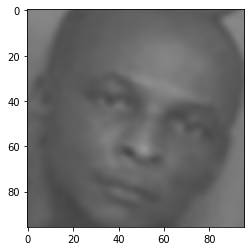

In [ ]:
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [ ]:
%time val_dataset = get_dataset(Val_paths , Val_labels , train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 29.7 ms, sys: 0 ns, total: 29.7 ms
Wall time: 30.9 ms
(32, 96, 96, 3)
(32, 7)


angry


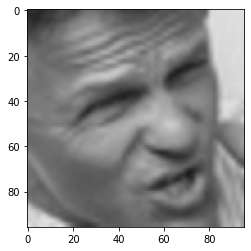

In [ ]:
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [ ]:
from tensorflow.keras.applications import EfficientNetB2

backbone = EfficientNetB2(
    input_shape=(96, 96, 3),
    include_top=False
)


model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

# model.summary()

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(Train_paths)//BATCH_SIZE,
    epochs=12,
    validation_data=val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
    class_weight=class_weight
)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/12
672/672 [==============================] - 3563s 5s/step - loss: 2.8565 - accuracy: 0.3900 - precision: 0.6516 - recall: 0.1734 - val_loss: 1.4544 - val_accuracy: 0.4565 - val_precision: 0.5957 - val_recall: 0.2645
Epoch 2/12
672/672 [==============================] - 107s 157ms/step - loss: 2.3822 - accuracy: 0.4930 - precision: 0.6967 - recall: 0.2801 - val_loss: 1.2434 - val_accuracy: 0.5396 - val_precision: 0.7152 - val_recall: 0.3577
Epoch 3/12
672/672 [==============================] - 104s 155ms/step - loss: 2.2091 - accuracy: 0.5274 - precision: 0.7089 - recall: 0.3315 - val_loss: 1.3121 - val_accuracy: 0.5064 - val_precision: 0.6256 - val_recall: 0.3531
Epoch 4/12
672/672 [==============================] - 104s 155ms/step - loss: 2.0907 - accuracy: 0.5476 - precision: 0.7158 - recall: 0.3675 - val_loss: 1.2202 - val_accuracy: 0.54

In [ ]:
model.layers[0].trainable = False

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5",verbose=1,save_best_only=True,save_weights_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 3, 3, 1408)        7768569   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1408)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               180352    
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 903       
Total params: 7,949,824
Trainable params: 181,255
Non-trainable params: 7,768,569
_________________________________________________________________


In [ ]:
  history = model.fit(
    train_dataset,
    steps_per_epoch=len(Train_paths)//BATCH_SIZE,
    epochs=20,
    callbacks=[checkpoint , early_stop],
    validation_data=val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
    class_weight=class_weight
)

Epoch 1/20
672/672 [==============================] - 102s 150ms/step - loss: 1.6527 - accuracy: 0.6327 - precision: 0.7491 - recall: 0.5005 - val_loss: 1.1084 - val_accuracy: 0.5961 - val_precision: 0.6815 - val_recall: 0.5024

Epoch 00001: val_loss improved from inf to 1.10844, saving model to best_weights.h5
Epoch 2/20
672/672 [==============================] - 103s 154ms/step - loss: 1.6170 - accuracy: 0.6366 - precision: 0.7483 - recall: 0.5097 - val_loss: 1.0699 - val_accuracy: 0.6051 - val_precision: 0.7014 - val_recall: 0.4973

Epoch 00002: val_loss improved from 1.10844 to 1.06992, saving model to best_weights.h5
Epoch 3/20
672/672 [==============================] - 104s 155ms/step - loss: 1.5919 - accuracy: 0.6424 - precision: 0.7532 - recall: 0.5149 - val_loss: 1.0947 - val_accuracy: 0.6060 - val_precision: 0.6954 - val_recall: 0.4972

Epoch 00003: val_loss did not improve from 1.06992
Epoch 4/20
672/672 [==============================] - 104s 156ms/step - loss: 1.5149 - acc

***Testing***

In [ ]:
from tensorflow.keras.applications import EfficientNetB2

backbone = EfficientNetB2(
    input_shape=(96, 96, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
model.load_weights("best_weights.h5")

In [ ]:
test_image_paths = list(te_path.glob("*/*"))
test_image_paths = list(map(lambda x : str(x) , test_image_paths))
test_labels = list(map(lambda x : get_label(x) , test_image_paths))

test_labels = Le.transform(test_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [96 , 96] , method="bilinear")
    return image , label

test_dataset = (
     tf.data.Dataset
    .from_tensor_slices((test_image_paths, test_labels))
    .map(decode_image)
    .batch(BATCH_SIZE)
)

In [ ]:
image , label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(32, 96, 96, 3)
(32, 7)


surprise


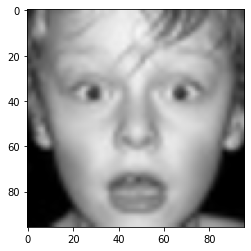

In [ ]:
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [ ]:
# Evaluating the loaded model
loss, acc, prec, rec = model.evaluate(test_dataset)

print(" Testing Acc : " , acc)
print(" Testing Precision " , prec)
print(" Testing Recall " , rec)

225/225 [==============================] - 937s 4s/step - loss: 1.0233 - accuracy: 0.6290 - precision: 0.7081 - recall: 0.5458
 Testing Acc :  0.6290053129196167
 Testing Precision  0.7081149220466614
 Testing Recall  0.545834481716156


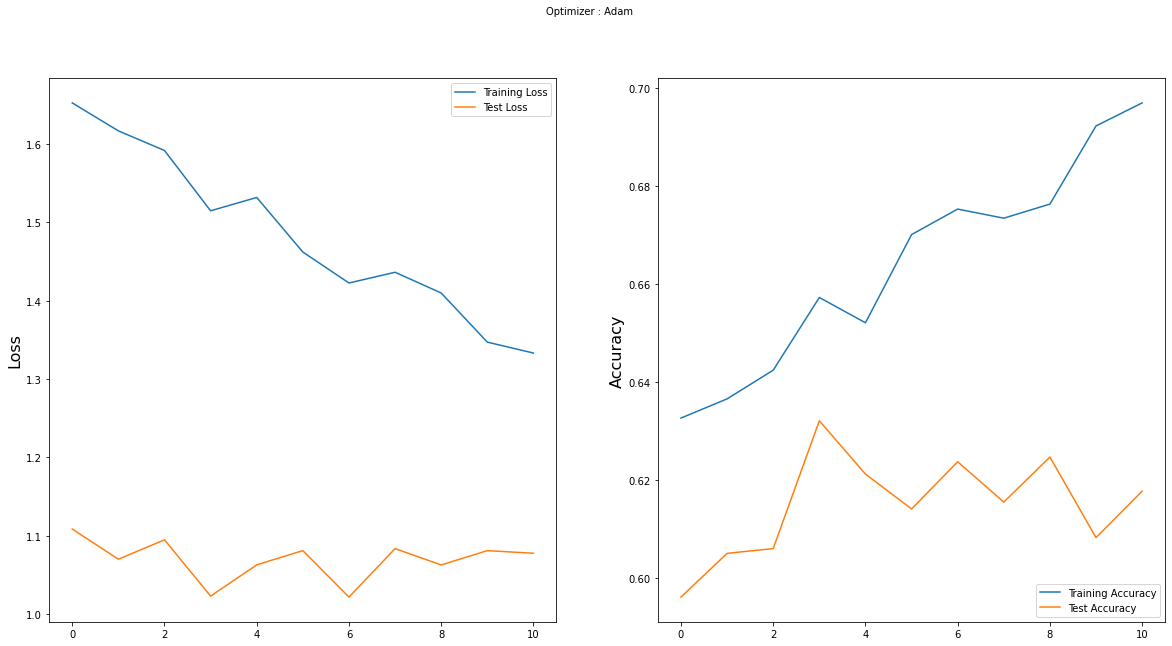

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.legend(loc='lower right')
plt.show()